In [42]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import rgb2flatPCA
from sklearn.metrics import accuracy_score
import math
from sklearn.metrics import classification_report
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from joblib import dump, load

# Define the batch size for data processing
batch_size = 256


### read the data

In [43]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### add the path of the images

In [44]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])


train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)
train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,../../data/faces/9855553@N08/coarse_tilt_align...
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,../../data/faces/114841417@N06/coarse_tilt_ali...
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,../../data/faces/66870968@N06/coarse_tilt_alig...
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,../../data/faces/8187011@N06/coarse_tilt_align...
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,../../data/faces/114841417@N06/coarse_tilt_ali...


#### add column for check if the image exists
it will help us to detect if there is any missing image, or if there is any bug in the path construction

In [45]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path,img_exists
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,../../data/faces/9855553@N08/coarse_tilt_align...,True
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,../../data/faces/114841417@N06/coarse_tilt_ali...,True
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,../../data/faces/66870968@N06/coarse_tilt_alig...,True
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,../../data/faces/8187011@N06/coarse_tilt_align...,True
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,../../data/faces/114841417@N06/coarse_tilt_ali...,True


In [46]:
def encode_gender_age(train_data, val_data, test_data):
    """Encodes gender and age combinations into a single label, handling unseen labels."""

    train_data['gender_age_combined'] = train_data['gender'].astype(str) + '_' + train_data['age'].astype(str)
    val_data['gender_age_combined'] = val_data['gender'].astype(str) + '_' + val_data['age'].astype(str)
    test_data['gender_age_combined'] = test_data['gender'].astype(str) + '_' + test_data['age'].astype(str)

    gender_age_encoder = LabelEncoder()
    train_data['gender_age_label'] = gender_age_encoder.fit_transform(train_data['gender_age_combined'])

    # Function to handle unseen labels
    def transform_with_unknown(data, encoder):
        known_classes = set(encoder.classes_)
        data['gender_age_label'] = data['gender_age_combined'].apply(
            lambda x: encoder.transform([x])[0] if x in known_classes else -1
        ) # assign -1 to unseen label.
        return data

    val_data = transform_with_unknown(val_data, gender_age_encoder)
    test_data = transform_with_unknown(test_data, gender_age_encoder)

    num_classes = len(gender_age_encoder.classes_)

    train_data.drop('gender_age_combined', axis=1, inplace=True)
    val_data.drop('gender_age_combined', axis=1, inplace=True)
    test_data.drop('gender_age_combined', axis=1, inplace=True)

    return train_data, val_data, test_data, num_classes, gender_age_encoder

train_data, val_data, test_data, num_classes, gender_age_encoder = encode_gender_age(train_data, val_data, test_data)

num_classes = len(gender_age_encoder.classes_)
print("gender_age classes:", gender_age_encoder.classes_)
train_data.head(5)

gender_age classes: ['f_(0, 2)' 'f_(15, 20)' 'f_(25, 32)' 'f_(38, 43)' 'f_(4, 6)' 'f_(48, 53)'
 'f_(60, 100)' 'f_(8, 23)' 'm_(0, 2)' 'm_(15, 20)' 'm_(25, 32)'
 'm_(38, 43)' 'm_(4, 6)' 'm_(48, 53)' 'm_(60, 100)' 'm_(8, 23)' 'u_(0, 2)'
 'u_(25, 32)' 'u_(60, 100)' 'u_(8, 23)']


,user_id,face_id,original_image,age,gender,img_path,img_exists,gender_age_label
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,../../data/faces/9855553@N08/coarse_tilt_align...,True,14
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,../../data/faces/114841417@N06/coarse_tilt_ali...,True,9
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,../../data/faces/66870968@N06/coarse_tilt_alig...,True,10
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,../../data/faces/8187011@N06/coarse_tilt_align...,True,16
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,../../data/faces/114841417@N06/coarse_tilt_ali...,True,1


### Filter out any rows where the image doesn't exist

In [47]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

### Define a generator function to process images in batches

In [48]:



def image_batch_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    num_batches = math.ceil(num_samples / batch_size)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        batch_paths = image_paths[start_idx:end_idx]
        batch_features = rgb2flatPCA(batch_paths) / 255.0  # Normalize to [0,1]
        batch_labels = labels[start_idx:end_idx]

        yield batch_features, batch_labels

### Extract image paths and labels

In [49]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['gender_age_label'].values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['gender_age_label'].values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['gender_age_label'].values

### Print dataset sizes

In [50]:
print(f"Training samples: {len(train_image_paths)}")
print(f"Validation samples: {len(val_image_paths)}")
print(f"Test samples: {len(test_image_paths)}")
print(f"Number of classes: {num_classes}")

Training samples: 11856
Validation samples: 2964
Test samples: 3731
Number of classes: 20


### Extract features for training and validation

In [51]:
print("Extracting features for training data...")
print(f"Processing all {len(train_image_paths)} training samples")

Extracting features for training data...
Processing all 11856 training samples


### Define a function to extract features in batches

In [52]:
def extract_features_in_batches(image_paths, batch_size=64):
    """Extract features from images in batches to manage memory."""
    num_samples = len(image_paths)
    num_batches = math.ceil(num_samples / batch_size)
    all_features = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        
        print(f"\rProcessing batch {i+1}/{num_batches}", end="")
        
        batch_paths = image_paths[start_idx:end_idx]
        batch_features = rgb2flatPCA(batch_paths) / 255.0  # Normalize to [0,1]
        
        all_features.append(batch_features)
    
    print("\nFeature extraction complete.")
    return np.vstack(all_features)

In [53]:
X_train = extract_features_in_batches(train_image_paths, batch_size=batch_size)
y_train = train_labels

print("Extracting features for validation data...")
print(f"Processing all {len(val_image_paths)} validation samples")

X_val = extract_features_in_batches(val_image_paths, batch_size=batch_size)
y_val = val_labels


print("Creating and training RandomForestClassifier model...")

Processing batch 47/47
Feature extraction complete.
Extracting features for validation data...
Processing all 2964 validation samples
Processing batch 12/12
Feature extraction complete.
Creating and training RandomForestClassifier model...


### Create a pipeline with scaling and RandomeForest
This is much more memory efficient for large datasets
Create a pipeline that scales data (optional for RF) and then trains a RandomForestClassifier

In [54]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling can be useful even though RF doesn't strictly require it
    ('rf', RandomForestClassifier(
        n_estimators=100,           # Number of trees in the forest
        criterion='gini',           # Criterion to measure split quality; can also use 'entropy'
        max_depth=None,             # Expand nodes until all leaves are pure or until minimum sample split
        class_weight='balanced',    # Adjust weights inversely proportional to class frequencies
        random_state=42,            # For reproducibility
        verbose=1,                  # Controls verbosity during training
        n_jobs=-1                   # Use all available cores for parallel processing
    ))
])

### define the model and train it

In [55]:
# Fit the pipeline directly
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42, verbose=1))])

### Evaluate the model on test data

In [56]:


# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


# Extract features for test data
print("Extracting features for test data...")
print(f"Processing all {len(test_image_paths)} test samples")

X_test = extract_features_in_batches(test_image_paths, batch_size=batch_size)
y_test = test_labels

# Evaluate on test data
test_preds = model.predict(X_test)  # Use X_test instead of test_data
test_accuracy = accuracy_score(y_test, test_preds)  # Use y_test instead of test_data
print(f"Test Accuracy: {test_accuracy:.4f}")

Extracting features for test data...
Processing all 3731 test samples
Processing batch 15/15
Feature extraction complete.
Test Accuracy: 0.1943


### Visualize results

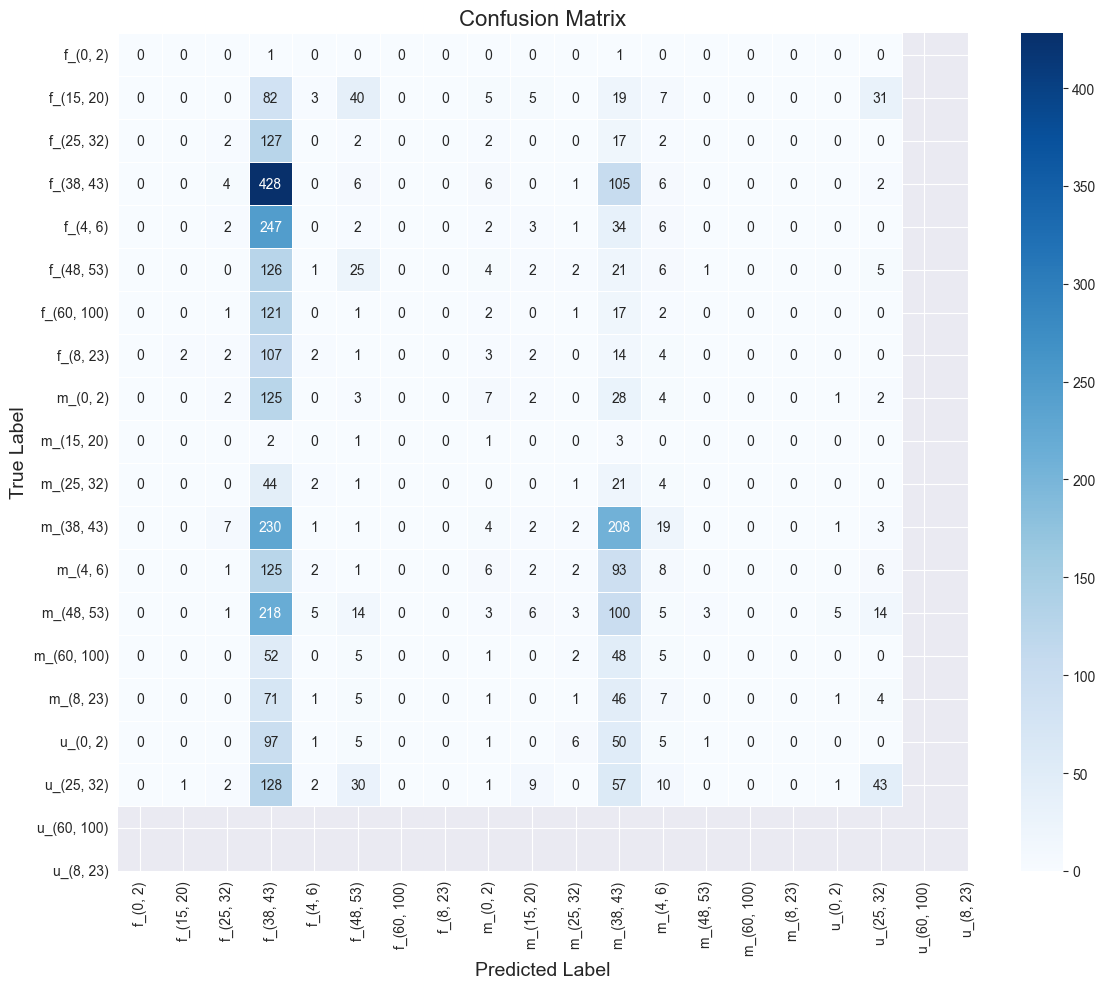

In [57]:

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Set up figure size
plt.figure(figsize=(12, 10))

# Create a heatmap without masking zero values for better visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, 
            xticklabels=gender_age_encoder.classes_,
            yticklabels=gender_age_encoder.classes_)

# Labels and title
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Improve layout and save figure
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)  # Higher DPI for better quality
plt.show()

### Classification report

In [58]:

# Get the unique classes in your test data
unique_classes = np.unique(y_test)

# Generate classification report using the labels parameter
report = classification_report(
    y_test, 
    test_preds, 
    labels=unique_classes,
    target_names=[gender_age_encoder.classes_[i] for i in unique_classes],
    zero_division=0  # Handles the division by zero error by setting precision and recall to 0
)

# Print the classification report with better formatting
print("=" * 50)
print("Classification Report")
print("=" * 50)
print(report)
print("=" * 50)


Classification Report
              precision    recall  f1-score   support

   u_(8, 23)       0.00      0.00      0.00         2
    f_(0, 2)       0.00      0.00      0.00       192
  f_(15, 20)       0.08      0.01      0.02       152
  f_(25, 32)       0.18      0.77      0.30       558
  f_(38, 43)       0.00      0.00      0.00       297
    f_(4, 6)       0.17      0.13      0.15       193
  f_(48, 53)       0.00      0.00      0.00       145
 f_(60, 100)       0.00      0.00      0.00       137
   f_(8, 23)       0.14      0.04      0.06       174
    m_(0, 2)       0.00      0.00      0.00         7
  m_(15, 20)       0.05      0.01      0.02        73
  m_(25, 32)       0.24      0.44      0.31       478
  m_(38, 43)       0.08      0.03      0.05       246
    m_(4, 6)       0.60      0.01      0.02       377
  m_(48, 53)       0.00      0.00      0.00       113
 m_(60, 100)       0.00      0.00      0.00       137
   m_(8, 23)       0.00      0.00      0.00       166
    u

### Save the model

In [59]:
dump(model, 'RF_gray_gender_age_classifier.joblib')
dump(gender_age_encoder, 'gender_age_encoder.joblib')
print("Model saved successfully.")

Model saved successfully.


In [60]:
# Function to predict gender_age range for a new image
def predict_gender_age(image_path, model, gender_age_encoder):
    """Predict gender and age for a given face image."""
    # Extract features
    features = rgb2flatPCA([image_path]) / 255.0
    
    # Apply the same scaling used during training (if using a pipeline with StandardScaler)
    if hasattr(model, 'named_steps') and 'scaler' in model.named_steps:
        features = model.named_steps['scaler'].transform(features)
    
    # Make prediction
    pred_class = model.predict(features)[0]
    
    # Get class probabilities if available
    if hasattr(model, 'predict_proba'):
        pred_probs = model.predict_proba(features)[0]
        confidence = pred_probs[pred_class]
    else:
        # For RandomForestClassifier without calibration, we can't get probabilities
        # Use decision function instead as a rough proxy for confidence
        decision_values = model.decision_function(features)
        # Normalize to [0, 1] range roughly
        confidence = 1 / (1 + np.exp(-np.abs(decision_values[0][pred_class])))
    
    # Convert to gender_age range
    pred_gender_age_range = gender_age_encoder.classes_[pred_class]
    
    return pred_gender_age_range, confidence

# Example usage:
"""
# Load the model
image_path = "path/to/new/face/image.jpg"
model = load('linear_svc_gender_age_classifier.joblib')
gender_age_encoder = load('gender_age_encoder.joblib')

# Make prediction
pred_gender_age, confidence = predict_gender_age(image_path, model, gender_age_encoder)
print(f"Predicted gender_age range: {pred_gender_age} with confidence {confidence:.2f}")
"""


'\n# Load the model\nimage_path = "path/to/new/face/image.jpg"\nmodel = load(\'linear_svc_gender_age_classifier.joblib\')\ngender_age_encoder = load(\'gender_age_encoder.joblib\')\n\n# Make prediction\npred_gender_age, confidence = predict_gender_age(image_path, model, gender_age_encoder)\nprint(f"Predicted gender_age range: {pred_gender_age} with confidence {confidence:.2f}")\n'